3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step   
Scaled MAE: 0.4107, Scaled MSE: 0.2669, Scaled R2: 0.1134
Real MAE: 10.5635, Real MSE: 176.5547, Real R2: 0.1134
✅ Saved predictions_unseen_std.csv


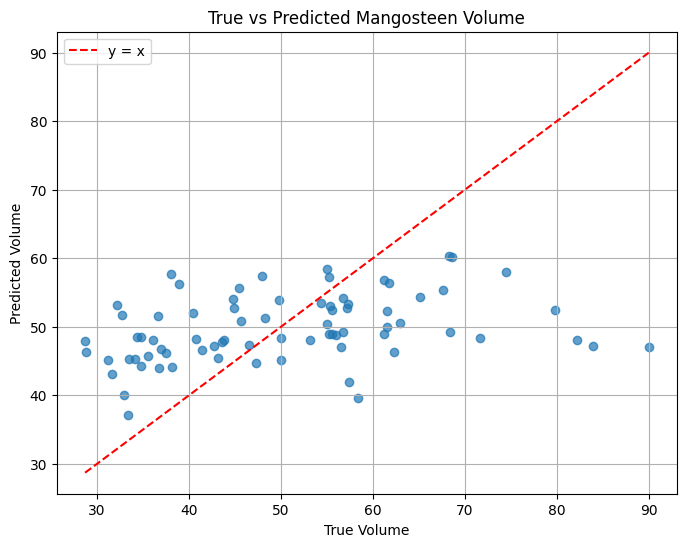

In [5]:
import os, cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import pandas as pd

# --- config ---
MODEL_PATH = "./mangosteen_volume_model_aug.h5"
SCALER_PATH = "./volume_scaler.save"
TEST_DATA_DIR = "./DataTest/combined"
TEST_VOLUME_DIR = "./DataTest/labels"
IMG_SIZE = 224

# --- load model + scaler ---
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

# --- load test data ---
def load_test_data(test_dir, volume_dir):
    imgs, vols, filenames = [], [], []
    for f in os.listdir(test_dir):
        if f.lower().endswith(('.png','.jpg','.jpeg')):
            base = f.split('.',1)[0]
            vf = os.path.join(volume_dir, base+".txt")
            if os.path.exists(vf):
                try:
                    vol = float(open(vf).read().strip())
                except:
                    continue
                img = cv2.imread(os.path.join(test_dir,f))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
                imgs.append(img.astype('float32')/255.0)
                vols.append(vol)
    if len(imgs) == 0:
        return np.array([]), np.array([])
    return np.stack(imgs,axis=0), np.array(vols)

X_test, y_true = load_test_data(TEST_DATA_DIR, TEST_VOLUME_DIR)

if X_test.size == 0:
    raise RuntimeError("No test images found. ตรวจสอบ TEST_DATA_DIR และ TEST_VOLUME_DIR")

# --- predict ---
y_pred_scaled = model.predict(X_test, batch_size=32).flatten()

# --- evaluate on scaled values (ก่อน de-normalize) ---
y_true_scaled = scaler.transform(y_true.reshape(-1,1)).flatten()
mae_scaled = mean_absolute_error(y_true_scaled, y_pred_scaled)
mse_scaled = mean_squared_error(y_true_scaled, y_pred_scaled)
r2_scaled = r2_score(y_true_scaled, y_pred_scaled)
print(f"Scaled MAE: {mae_scaled:.4f}, Scaled MSE: {mse_scaled:.4f}, Scaled R2: {r2_scaled:.4f}")

# --- de-normalize (กลับมาเป็นหน่วยจริง) ---
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()

# --- evaluate on real values (de-normalize) ---
mae_real = mean_absolute_error(y_true, y_pred)
mse_real = mean_squared_error(y_true, y_pred)
r2_real = r2_score(y_true, y_pred)
print(f"Real MAE: {mae_real:.4f}, Real MSE: {mse_real:.4f}, Real R2: {r2_real:.4f}")

# --- save predictions ---
df = pd.DataFrame({
    'true_volume': y_true,
    'predicted_volume': y_pred,
    'abs_error': np.abs(y_true - y_pred),
    'squared_error': (y_true - y_pred)**2
})
df.to_csv("predictions_unseen_std.csv", index=False)
print("✅ Saved predictions_unseen_std.csv")

# --- plot True vs Predicted ---
plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true),max(y_true)], [min(y_true),max(y_true)], 'r--', label='y = x')
plt.xlabel("True Volume")
plt.ylabel("Predicted Volume")
plt.title("True vs Predicted Mangosteen Volume")
plt.legend()
plt.grid(True)
plt.show()
#Real MAE: 10.7296, Real MSE: 175.8946, Real R2: 0.1167
#Real MAE: 10.5635, Real MSE: 176.5547, Real R2: 0.1134